In [1]:
# this notebook will downsample lightsheet data
# from here
#  /panfs/dong/3D_stitched_LS/20220725_SW220510_02_LS_6x_1000z
#  note we will  now load voxel size from the data itself
# and we load the extent as well
#

in v01 I look at standard deviation too

I'd also like to find the minimum value in the dataset other than 0

NOTE
if any part of a chunk is accessed, the whole chunk is read.

I should be able to speed things up by reading 64 slices at a time (potentially).

"
Typical chunk sizes are 128x128x64 or 256x256x16. The optimal chunk size is determined by the geometry of the image and it is not easy to specify rules for reproducing exactly the chunk sizes that Imaris will write into the hdf-file.
"

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib notebook
import os
from glob import glob
from os.path import join as pathjoin
import h5py
import time

import imp
import sys
sys.path.append('..')
import donglab_workflows as dw
imp.reload(dw)
import PIL.Image as Image
Image.MAX_IMAGE_PIXELS = None
import tifffile as tf # for 16 bit tiff
import h5py



/nafs/dtward/torch_venv/lib/python3.7/site-packages/ipykernel_launcher.py:10: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  # Remove the CWD from sys.path while we load stuff.


In [3]:
# todo, move into dongloab workflows and use for dragonfly as well

# downsample lightsheet

The mit data is stored in tif stacks
the size is
Image resolution is 1.8 µm x 1.8 µm x 2.0 µm (xyz), and the stack can be found at our network storage space at BMAP.



In [8]:
# input path, can be a directory or a filename
#input_path = '/home/dtward/bmaproot/panfs/dong/3D_stitched_LS/20220725_SW220510_02_LS/SW220510_02_LS_6x_1000z.ims'
input_path = '/panfs/dong/3D_stitched_LS/20220725_SW220510_02_LS/SW220510_02_LS_6x_1000z.ims'
image_type = 'ims' # can be ims or Tif

output_filename = None # generate automatically if None

# we need a temporary output directory for intermediate results (each slice)
#outdir = '/home/dtward/bmaproot/nafs/dtward/dong/donglab_resample_lightsheet_good_2022_09_06_tmp'
outdir = '/nafs/dtward/dong/donglab_resample_lightsheet_good_2022_09_06_tmp'

# res is the desired voxel size
dI = None # if none will load from data
res = 50.0 # perhaps we could use the 25 micron atlas (this can be any float)
channel = 0
dataset_string = f'DataSet/ResolutionLevel 0/TimePoint 0/Channel {channel}/Data' # not used for Tifs

# power to reduce dynamic range
power = np.ones(1,dtype=np.float32)*0.125

# blocksize and chunksize for looking for areas with no data and loading quickly
blocksize = 64 # 
chunksize = 32 # 

In [9]:
if dI is None and image_type == 'ims':
    f = h5py.File(input_path,'r')
    dI = dw.imaris_get_pixel_size(f)    
    xI = dw.imaris_get_x(f)
    f.close()
    
if output_filename is None:
    output_filename = os.path.splitext(os.path.split(input_path)[-1])[0] + '_ch_' + str(channel) + '_pow_' + str(power) + '_down.npz'
#output_filename = 'SYTO16_488_086780_109130_down.npz'    

print(f'Input path is {input_path}')
print(f'Output filename is {output_filename}')
print(f'Resolution is {dI}')
print(f'Desired resolution is {res}')
print(f'Dataset string is {dataset_string}')
print(f'tmp output dir is {outdir}')

# temporary output dir
os.makedirs(outdir,exist_ok=True)

Input path is /panfs/dong/3D_stitched_LS/20220725_SW220510_02_LS/SW220510_02_LS_6x_1000z.ims
Output filename is SW220510_02_LS_6x_1000z_ch_0_pow_[0.125]_down.npz
Resolution is [1. 1. 1.]
Desired resolution is 50.0
Dataset string is DataSet/ResolutionLevel 0/TimePoint 0/Channel 0/Data
tmp output dir is /nafs/dtward/dong/donglab_resample_lightsheet_good_2022_09_06_tmp


In [10]:
# I want 50 micron
down = np.floor(res/dI).astype(int)
print(f'Downsampling factors are {down}')
print(f'Downsampled res {dI*down}')

Downsampling factors are [50 50 50]
Downsampled res [50. 50. 50.]


In [11]:
# build a tif class with similar interface
class TifStack:
    '''We need a tif stack with an interface that will load a slice one at a time
    We assume each tif has the same size
    We assume 16
    '''
    def __init__(self,input_directory,pattern='*.tif'):
        self.input_directory = input_directory
        self.pattern = pattern
        self.files = glob(pathjoin(input_directory,pattern))
        self.files.sort()
        test = Image.open(self.files[0])
        self.nxy = test.size
        test.close()
        self.nz = len(self.files)
        self.shape = (self.nz,self.nxy[1],self.nxy[0]) # note, it is xy not rowcol
    def __getitem__(self,i):
        return tf.imread(self.files[i])/(2**16-1)
    def __len__(self):
        return len(self.files)
    def close(self):
        pass # nothing necessary
    


In [12]:
# load the data

if image_type == 'tif':
    data = TifStack(input_directory)
    
elif image_type == 'ims':
    data_ = h5py.File(input_path,mode='r')
    data = data_[dataset_string]
    

In [10]:
print(f'Dataset shape {data.shape}')

Dataset shape (8448, 17664, 12672)


In [13]:
nI = np.array(data.shape)
#xI = [np.arange(n)*d - (n-1)/2.0*d for n,d in zip(nI,dI)] # already computed above
# NOTE: the imaging data is smaller than the saved data because the saved data is a multiple of 64
nIreal = np.array([len(x) for x in xI])

In [14]:
xId = [dw.downsample(x,[d]) for x,d in zip(xI,down)]
dId = [x[1]-x[0] for x in xId]

In [13]:
dId

[50.0, 50.0, 50.0]

<IPython.core.display.Javascript object>


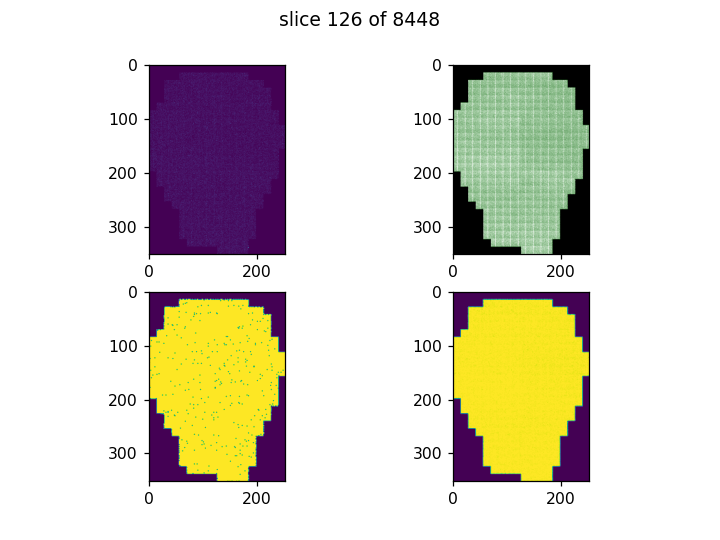

Finished loading slice 0 of 8448, time 0.17888545989990234 s
Finished loading slice 1 of 8448, time 0.13571429252624512 s
Finished loading slice 2 of 8448, time 0.13011908531188965 s
Finished loading slice 3 of 8448, time 0.14974260330200195 s
Finished loading slice 4 of 8448, time 0.13455796241760254 s
Finished loading slice 5 of 8448, time 0.12926506996154785 s
Finished loading slice 6 of 8448, time 0.13062310218811035 s
Finished loading slice 7 of 8448, time 0.12848258018493652 s
Finished loading slice 8 of 8448, time 0.13164782524108887 s
Finished loading slice 9 of 8448, time 0.12992286682128906 s
Finished loading slice 10 of 8448, time 0.13010787963867188 s
Finished loading slice 11 of 8448, time 0.13112664222717285 s
Finished loading slice 12 of 8448, time 0.1293032169342041 s
Finished loading slice 13 of 8448, time 0.12493085861206055 s
Finished loading slice 14 of 8448, time 0.1354539394378662 s
Finished loading slice 15 of 8448, time 0.12441539764404297 s
Finished loading sli

/nafs/dtward/torch_venv/lib/python3.7/site-packages/ipykernel_launcher.py:85: RuntimeWarning: invalid value encountered in true_divide
/nafs/dtward/torch_venv/lib/python3.7/site-packages/ipykernel_launcher.py:87: RuntimeWarning: invalid value encountered in true_divide
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Finished loading slice 48 of 8448, time 0.12543368339538574 s
Finished loading slice 49 of 8448, time 0.29198312759399414 s
Finished loading slice 50 of 8448, time 0.12975573539733887 s
Finished loading slice 51 of 8448, time 0.12945866584777832 s
Finished loading slice 52 of 8448, time 0.12775945663452148 s
Finished loading slice 53 of 8448, time 0.12999653816223145 s
Finished loading slice 54 of 8448, time 0.12789607048034668 s
Finished loading slice 55 of 8448, time 0.12865424156188965 s
Finished loading slice 56 of 8448, time 0.12739920616149902 s
Finished loading slice 57 of 8448, time 0.12873125076293945 s
Finished loading slice 58 of 8448, time 0.12732696533203125 s
Finished loading slice 59 of 8448, time 0.12866616249084473 s
Finished loading slice 60 of 8448, time 0.12764668464660645 s
Finished loading slice 61 of 8448, time 0.12860465049743652 s
Finished loading slice 62 of 8448, time 0.13914799690246582 s
Finished loading slice 63 of 8448, time 0.12937450408935547 s
Finished

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Finished loading slice 99 of 8448, time 0.27639102935791016 s
Finished loading slice 100 of 8448, time 0.12923455238342285 s
Finished loading slice 101 of 8448, time 0.13034677505493164 s
Finished loading slice 102 of 8448, time 0.12802577018737793 s
Finished loading slice 103 of 8448, time 0.12966060638427734 s
Finished loading slice 104 of 8448, time 0.12893104553222656 s
Finished loading slice 105 of 8448, time 0.12923407554626465 s
Finished loading slice 106 of 8448, time 0.12766122817993164 s
Finished loading slice 107 of 8448, time 0.17771077156066895 s
Finished loading slice 108 of 8448, time 0.12917017936706543 s
Finished loading slice 109 of 8448, time 0.12950825691223145 s
Finished loading slice 110 of 8448, time 0.1278226375579834 s
Finished loading slice 111 of 8448, time 0.12946295738220215 s
Finished loading slice 112 of 8448, time 0.12783598899841309 s
Finished loading slice 113 of 8448, time 0.12945270538330078 s
Finished loading slice 114 of 8448, time 0.12752032279968

KeyboardInterrupt: 

In [15]:
# okay now I have to iterate over the dataset
# note this is currently not doing wieghts
# we need to save intermediate outputs (each slice) in case of errors
fig,ax = plt.subplots(2,2)
ax = ax.ravel()
working = []
working2 = []
workingw = []
output = []
output2 = []
outputw = []
start = time.time()
for i in range(nIreal[0]):
    starti = time.time()
    outname = os.path.join(outdir,f'{i:06d}_s.npy')
    


    if os.path.exists(outname):
        # what happens if it fails in the middle of a chunk?
        sd = np.load(outname)
        s2d = np.load(outname.replace('_s','_s2'))
        wd = np.load(outname.replace('_s','_w'))
    else:
        # load a whole chunk
        if not i%chunksize:
            data_chunk = data[i:i+chunksize]
        # use this for weights
        #s_all = data[i,:,:]
        # it's possible that this will fail if I haven't defined data_chunk yet
        try:
            s_all = data_chunk[i%chunksize,:,:]
        except:
            # we need to load, not starting at i
            # but at the beginning of the chunk
            data_chunk = data[i//chunksize:i//chunksize+chunksize]
            s_all = data_chunk[i%chunksize,:,:]
        s = s_all[:nIreal[1]+1,:nIreal[2]+1]**power # test reduce dynamic range before downsampling with this power
        s2 = s**2
        #w = (s>0).astype(float)
        # this is not a good way to get weights, 
        # we need to look for a 64x64 block of all zeros
        
        s_all_block = s_all.reshape(s_all.shape[0]//blocksize,blocksize,s_all.shape[1]//blocksize,blocksize)
        tmp = np.logical_not(np.all(s_all_block==0,axis=(1,3))).astype(np.uint8)
        s_all_w = np.ones_like(s_all_block)
        s_all_w *= tmp[:,None,:,None]
        s_all_w = s_all_w.reshape(s_all.shape)
        w = s_all_w[:nIreal[1]+1,:nIreal[2]+1].astype(power.dtype)

        
        sd = dw.downsample((s*w),down[1:])
        s2d = dw.downsample((s2*w),down[1:])
        wd = dw.downsample(w,down[1:])
        sd /= wd
        sd[np.isnan(sd)] = 0.0
        s2d /= wd
        s2d[np.isnan(s2d)] = 0.0
        
        np.save(outname,sd)
        np.save(outname.replace('_s','_w'),wd)
        np.save(outname.replace('_s','_s2'),s2d)
    
    ax[0].cla()
    wd0 = wd>0.0
    if np.any(wd0):
        vmin = np.min(sd[wd0])
        vmax = np.max(sd[wd0])
    else:
        vmin = None
        vmax = None
    ax[0].cla()
    ax[0].imshow(sd,vmin=vmin,vmax=vmax)
    ax[2].cla()
    ax[2].imshow(wd,vmin=0,vmax=1)
    working.append(sd)
    working2.append(s2d)
    workingw.append(wd)
    
    if len(working) == down[0]:
        workingw_stack = np.stack(workingw)
        out = dw.downsample(np.stack(working)*workingw_stack,[down[0],1,1])
        out2 = dw.downsample(np.stack(working2)*workingw_stack,[down[0],1,1])
        outw = dw.downsample(workingw_stack,[down[0],1,1])        
        out /= outw
        out[np.isnan(out)] = 0.0
        out2 /= outw
        out2[np.isnan(out2)] = 0.0
        outstd = out2 - out**2
        outstd[outstd<0]=0
        outstd = np.sqrt(outstd)
        wd0 = (wd>0.0)[None]
        if np.any(wd0):
            outshow = (out[0] - np.min(out[wd0]))/(np.quantile(out[wd0],0.99) - np.min(out[wd0]))
            outshowstd = (outstd[0] - np.min(outstd[wd0]))/(np.quantile(outstd[wd0],0.99) - np.min(outstd[wd0]))
        else:
            outshow = (out[0] - np.min(out))/(np.quantile(out,0.99) - np.min(out))
            outshowstd = (outstd[0] - np.min(outstd))/(np.quantile(outstd,0.99) - np.min(outstd))
        ax[1].cla()
        ax[1].imshow(np.stack((outshow,outshowstd,outshow),-1))
        ax[3].cla()
        ax[3].imshow(outw[0],vmin=0,vmax=1)
        output.append(out)
        output2.append(out2)
        outputw.append(outw)
        working = []
        workingw = []
        working2 = []
    fig.suptitle(f'slice {i} of {data.shape[0]}')
    fig.canvas.draw()
    print(f'Finished loading slice {i} of {data.shape[0]}, time {time.time() - starti} s')
output = np.concatenate(output)        
Id = output
wd = np.concatenate(outputw)
print(f'Finished downsampling, time {time.time() - start}')

In [ ]:
np.savez(output_filename,I=Id,I2=np.concatenate(output2),xI=np.array(xId,dtype='object'),w=wd) # note specify object to avoid "ragged" warning

In [ ]:
fig,ax = dw.draw_slices(Id,xId)
fig.suptitle(output_filename)
fig.savefig(output_filename.replace('npz','jpg'))

In [ ]:
out.shape